# Notebook for building and testing the model     

In this notebook, I will build and run an initial test over the first 2,048 rows of the data to ensure proper functionality before deploying on midway2 to train on GPUs. 

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
# import torchvision
# from torchvision import datasets, transforms
# from torchvision.utils import save_image

# from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sys

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [5]:
# cuda setup
device = torch.device("cuda")
kwargs = {'num_workers': 2, 'pin_memory': True} 

In [6]:
# hyper params
batch_size = 128
latent_size = 10
epochs = 10

In [7]:
# reading in the data
dat = np.genfromtxt('traindata/trip-2021-07-28.csv', delimiter=',')[1:,]

In [8]:
# need to subset this in a conditional fashion (i.e., each gamma value, here class c, has 1000 data points)
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [9]:
# create an 80/20 split in each data set
temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.2, random_state=42) for i in np.arange(len(gamma))]

# for each gamma value...
Xltrain = []
Xltest = []
altrain = []
altest = []
for t in np.arange(len(temp)):
    Xltrain.append(temp[t][0])
    Xltest.append(temp[t][1])
    altrain.append(temp[t][2])
    altest.append(temp[t][3])

NameError: name 'train_test_split' is not defined

In [10]:
# creating a simple matrix of training data (...x2, ...x1) 
tr_dat = TensorDataset(torch.tensor(np.vstack((np.hstack((Xltrain[0:5])), np.repeat(gamma[0:5],len(Xltrain[0])))).T), torch.tensor(np.hstack((altrain[0:5]))))

NameError: name 'Xltrain' is not defined

In [900]:
tr_dl = DataLoader(tr_dat, batch_size=128, shuffle=True, num_workers=2)

In [899]:
te_dat = TensorDataset(torch.tensor(np.vstack((np.hstack((Xltest[0:5])), np.repeat(gamma[0:5],len(Xltest[0])))).T), torch.tensor(np.hstack((altest[0:5]))))
te_dl = DataLoader(te_dat, num_workers=2)

In [7]:
class BaselineNet(nn.Module):
    def __init__(self, hidden1):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(2, hidden1),
            nn.ELU(),
            nn.Linear(hidden1, 256), 
            nn.ELU(),
            nn.Linear(256, 48),
            nn.ReLU(),
            nn.Linear(48, 1), 
        )
        self.double()

    def forward(self, xg):
        a = F.relu(self.fc1(xg))
        return a

In [8]:
bnet = BaselineNet(512)
bnet.eval()
mse_loss = nn.MSELoss()
optimizer = optim.Adagrad(bnet.parameters(), lr=2e-3)

In [878]:
len(tr_dl.dataset)

800

In [9]:
def train(dl, model, loss_fn, optim):
    size = len(dl.dataset)
    for batch, (xg, a) in enumerate(dl):
        # Compute prediction error
        pred = model(xg)
        loss = loss_fn(pred, a)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if batch % 10 == 0:
        #     loss, current = loss.item(), batch * len(xg)
        #     print(f"loss: {loss:>.2f}  [{current:>2d}/{size:>2d}]")

        return loss.item()

In [10]:
def test(dl, model, loss_fn):
    size = len(dl.dataset)
    num_batches = len(dl)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for xg, a in dl:
            pred = model(xg)
            test_loss += loss_fn(pred, a).item()
    test_loss /= num_batches
    return test_loss
    #print(f"Test Error: Avg loss: {test_loss:>.2f} \n")

In [11]:
epochs = 500
for t in range(epochs):
    trloss = train(train_loader, bnet, mse_loss, optimizer)
    teloss = test(test_loader, bnet, mse_loss)
    if t%100 == 0:
        print(f"Epoch {t+1} - ")
        print(f"\tTrain loss: {trloss:.2f}")
        print(f"\tTest loss: {teloss:.2f}")
print("Done!")

NameError: name 'train_loader' is not defined

In [35]:
bnet.eval()
predicted = np.zeros((test_size))
truth = np.zeros((test_size))
for i, (freq_gamma, age) in enumerate(test_loader):
        optimizer.zero_grad()
        age_pred = bnet(freq_gamma)
        loss = mse_loss(age_pred.unsqueeze(1),age.unsqueeze(1)).detach().cpu()
        if i < int(test_size/batch_size): # so that it does not include the last batch that is not of size batch_size
            predicted[i*batch_size:(i+1)*batch_size]=age_pred.detach().squeeze().cpu().numpy()
            truth[i*batch_size:(i+1)*batch_size]=age.cpu().squeeze().numpy()
        else:
            predicted[i*batch_size:]=age_pred.detach().squeeze().cpu().numpy()
            truth[i*batch_size:]=age.cpu().squeeze().numpy()

In [36]:
r2_score(y_true=truth, y_pred=predicted)

0.9394965651856095

0.9698055801592798


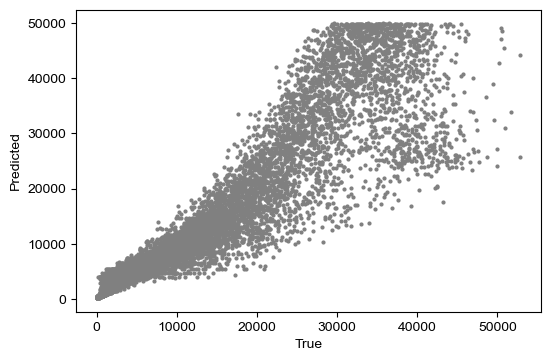

In [38]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(truth), np.exp(predicted), 'o',  color="grey", markersize=2)
res = sm.OLS(preds, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds), np.max(preds), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

In [ ]:
#torch.unsqueeze(torch.tensor(Xltrain[0]),1)
#bnet.forward(torch.tensor(Xltrain[0]), torch.tensor(np.repeat(gamma[0], len(Xltrain[0]))))
torch.tensor(Xltrain[0]).view(-1, torch.tensor(Xltrain[0]).size(0)).shape
torch.unsqueeze(torch.tensor(Xltrain[0]),1)
#print(torch.unsqueeze(torch.linspace(-1,1,10),-1).shape)
#bnet.forward(torch.tensor(Xltrain[0][1]),torch.tensor(gamma[0]))
#torch.unsqueeze(torch.tensor(Xltrain[0]),0).shape

## VAE implementation

Following the procedure in https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py, seems pretty similar to the architecture of the BaselineNet...

In [39]:
# from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self, features):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(2, 48)
        self.enc2 = nn.Linear(48, 128)
        self.enc3 = nn.Linear(128, features*2)
 
        # decoder 
        self.dec1 = nn.Linear(features, 48)
        self.dec2 = nn.Linear(48, 128)
        self.dec3 = nn.Linear(128, 1)

        self.double()

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x, features):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = self.enc3(x).view(-1, 2, features)

        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        reconstruction = torch.sigmoid(self.dec3(x))
        return reconstruction, mu, log_var
    
    def loss_function(self, *args):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        recons_loss = F.mse_loss(recons, input.view(-1,1))


        #kld_loss = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp())

        loss = recons_loss #+ kld_loss
        return loss

In [54]:
def final_loss(mse_loss, mu, logvar):
    """
    This function will add the reconstruction loss (MSELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    :param mse_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = mse_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [40]:
batch_size = 512
model = LinearVAE(features=16) # dimensionality of the latent variable
optimizer = optim.SGD(model.parameters(), lr=2e-3)

In [16]:
def train_vae(dl, model, loss_fn, optim):
    size = len(dl.dataset)
    for batch, (xg, a) in enumerate(dl):
        # Compute prediction error
        pred, mu, logvar = model(xg, features=16)
        step_loss = model.loss_function(*[pred, a, mu, logvar])

        # Backpropagation
        optimizer.zero_grad()
        step_loss.backward()
        optimizer.step()
        # if batch % 10 == 0:
        #     loss, current = loss.item(), batch * len(xg)
        #     print(f"loss: {loss:>.2f}  [{current:>2d}/{size:>2d}]")

        return step_loss.item()

In [20]:
def test_vae(dl, model, loss_fn):
    size = len(dl.dataset)
    num_batches = len(dl)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for xg, a in dl:
            pred, mu, logvar = model(xg, features=16)
            test_loss += model.loss_function(*[pred, a, mu, logvar]).item()
    test_loss /= num_batches
    return test_loss

In [41]:
epochs = 300
for t in range(epochs):
    trloss = train_vae(train_loader, model, mse_loss, optimizer)
    teloss = test_vae(test_loader, model, mse_loss)
    if t%100 == 0:
        print(f"Epoch {t+1} - ")
        print(f"\tTrain loss: {trloss:.2f}")
        print(f"\tTest loss: {teloss:.2f}")
print("Done!")

Epoch 1 - 
	Train loss: 73.49
	Test loss: 72.13
Epoch 101 - 
	Train loss: 64.52
	Test loss: 64.38
Epoch 201 - 
	Train loss: 62.14
	Test loss: 64.07
Done!


In [35]:
next(iter(train_loader))[1].view(-1,1)

tensor([[ 7.2626],
        [10.6502],
        [ 6.5043],
        [ 8.7878],
        [10.2316],
        [10.0399],
        [ 9.7390],
        [ 9.9021],
        [ 7.3434],
        [ 9.2693],
        [ 7.5751],
        [ 5.1299],
        [ 6.6026],
        [ 7.0892],
        [ 9.6652],
        [ 7.9466],
        [10.0277],
        [ 8.9392],
        [ 8.8905],
        [ 8.8069],
        [10.0233],
        [ 9.7454],
        [ 9.3155],
        [ 9.9909],
        [10.2664],
        [ 9.0328],
        [ 8.6704],
        [ 9.4511],
        [ 9.3284],
        [10.0452],
        [ 9.2378],
        [ 8.1611],
        [10.0659],
        [ 4.5218],
        [ 8.4978],
        [ 7.6372],
        [ 8.0330],
        [ 6.6134],
        [ 8.6983],
        [ 9.8875],
        [ 8.8782],
        [ 9.0638],
        [ 6.4394],
        [ 5.6419],
        [ 7.9248],
        [ 7.3840],
        [ 9.9214],
        [10.0431],
        [10.5627],
        [ 9.3969],
        [10.2421],
        [ 4.5747],
        [ 9.

In [44]:
batch_size=128
model.eval()
predicted = np.zeros((test_size))
truth = np.zeros((test_size))
for i, (freq_gamma, age) in enumerate(test_loader):
        optimizer.zero_grad()
        age_pred = model(freq_gamma, features=16)[0]
        loss = mse_loss(age_pred.unsqueeze(1),age.unsqueeze(1)).detach().cpu()
        if i < int(test_size/batch_size): # so that it does not include the last batch that is not of size batch_size
            predicted[i*batch_size:(i+1)*batch_size]=age_pred.detach().squeeze().cpu().numpy()
            truth[i*batch_size:(i+1)*batch_size]=age.cpu().squeeze().numpy()
        else:
            predicted[i*batch_size:]=age_pred.detach().squeeze().cpu().numpy()
            truth[i*batch_size:]=age.cpu().squeeze().numpy()

/usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16, 1, 1, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


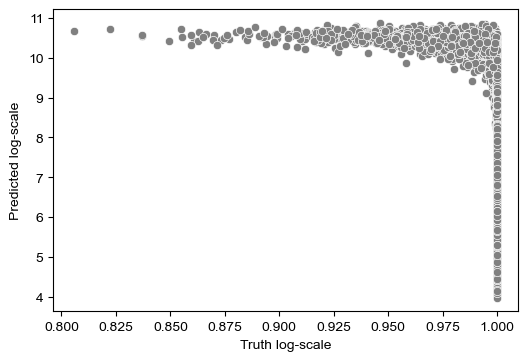

In [46]:
plt.figure(dpi=100)
sns.scatterplot(x=np.ravel(predicted), y=np.ravel(truth),  color="grey")
plt.xlabel("Truth log-scale")
plt.ylabel("Predicted log-scale")
plt.show()

In [763]:
# model.train()
# for e in range(800):
#     optimizer.zero_grad()

#     pred, mu, logvar = model(torch.tensor(np.vstack((Xltrain[0],np.repeat(gamma[0],len(Xltrain[0])))).T))
#     step_loss = mse_loss(pred, torch.unsqueeze(torch.tensor(np.hstack((altrain[0]))),1))

#     loss = final_loss(step_loss, mu, logvar)
#     loss.backward()

#     # update with current step regression parameters 
#     optimizer.step()

#     if e % 100 == 0:
#         print ('epoch [{}], Loss: {:.2f}'.format(e, loss.item()))

epoch [0], Loss: 295960.03
epoch [100], Loss: nan
epoch [200], Loss: nan
epoch [300], Loss: nan
epoch [400], Loss: nan
epoch [500], Loss: nan
epoch [600], Loss: nan
epoch [700], Loss: nan


In [747]:
torch.tensor(np.vstack((Xltrain[0],np.repeat(gamma[0],len(Xltrain[0])))).T).shape

torch.Size([800, 2])

### Rahul's linear regression implementation

In [13]:
class DoubleDataset(Dataset):
    def __init__(self, path_to_data, delimiter_flag=',', transforms=None):
        # first row indicates order of freq, gamma, age current set at:
        # First column Frequeny, Second column gamma, third column: age
        self.data_1 = torch.from_numpy(np.genfromtxt(path_to_data, delimiter=',')[1:,])
        self.transforms = transforms

    def __getitem__(self, index):
        assert self.data_1.shape[1] ==  3, 'datasets should be of size Nx3, where N is the number of samples'
        _freq = torch.log(self.data_1[index,0]).view(-1,1)
        _gamma =self.data_1[index,1].view(-1,1)
        _age = torch.log(self.data_1[index,2]).view(-1,1)

        if self.transforms is not None:
            _data1 = self.transforms(self.data_1)
        return torch.cat((_freq,_gamma),dim=1), _age

    def __len__(self):
        return self.data_1.shape[0]

In [14]:
# Create dataset for training and testing
theData = DoubleDataset('traindata/trip-2021-07-28.csv', ',')
train_size = int(0.8 * len(theData))
test_size = len(theData) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(theData, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
batch_size = 512

model = nn.Sequential(nn.Linear(2,500),nn.ELU(),nn.Linear(500,50),nn.ELU(),nn.Linear(50,1)).double().to(device)
mse_loss = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

NameError: name 'nn' is not defined

In [2]:
epochs = 500
model.train()
for epoch in range(epochs):
    loss_sum = 0.0

    for i, (freq_gamma, age) in enumerate(train_loader):
        optimizer.zero_grad()
        age_pred = model(freq_gamma.to(device))
        loss = mse_loss(age_pred.unsqueeze(1),age.unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
        
    print('Epoch: {}, Nats: {:.3f}'.format(epoch+1, loss_sum/(i+1)), end='\r')

final_train_bpd = loss_sum / len(train_loader)

NameError: name 'model' is not defined

In [918]:
model.eval()
predicted = np.zeros((test_size))
truth = np.zeros((test_size))
for i, (freq_gamma, age) in enumerate(test_loader):
        optimizer.zero_grad()
        age_pred = model(freq_gamma.to(device))
        loss = mse_loss(age_pred.unsqueeze(1),age.unsqueeze(1).to(device)).detach().cpu()
        if i < int(test_size/batch_size): # so that it does not include the last batch that is not of size batch_size
            predicted[i*batch_size:(i+1)*batch_size]=age_pred.detach().squeeze().cpu().numpy()
            truth[i*batch_size:(i+1)*batch_size]=age.cpu().squeeze().numpy()
        else:
            predicted[i*batch_size:]=age_pred.detach().squeeze().cpu().numpy()
            truth[i*batch_size:]=age.cpu().squeeze().numpy()
        print('Iter: {}/{}, Nats: {:.3f}'.format(i+1, len(test_loader), loss), end='\r')
        print('')

Iter: 1/20, Nats: 17.920
Iter: 2/20, Nats: 16.532
Iter: 3/20, Nats: 15.778
Iter: 4/20, Nats: 15.288
Iter: 5/20, Nats: 15.747
Iter: 6/20, Nats: 15.390
Iter: 7/20, Nats: 16.293
Iter: 8/20, Nats: 15.497
Iter: 9/20, Nats: 15.632
Iter: 10/20, Nats: 16.260
Iter: 11/20, Nats: 16.122
Iter: 12/20, Nats: 15.709
Iter: 13/20, Nats: 15.223
Iter: 14/20, Nats: 15.873
Iter: 15/20, Nats: 16.785
Iter: 16/20, Nats: 15.200
Iter: 17/20, Nats: 13.958
Iter: 18/20, Nats: 15.976
Iter: 19/20, Nats: 16.875
Iter: 20/20, Nats: 15.464


In [944]:
pred_array = np.ravel(np.asarray(predicted))
truth_array = np.ravel(np.asarray(truth))

In [945]:
pred_array

array([3.79341644, 7.78621745, 9.20566432, ..., 5.04297732, 8.33196194,
       9.94834752])

In [948]:
np.exp(pred_array)

array([   44.40785804,  2407.19499747,  9953.34859531, ...,
         154.93060645,  4154.56056573, 20917.62774599])

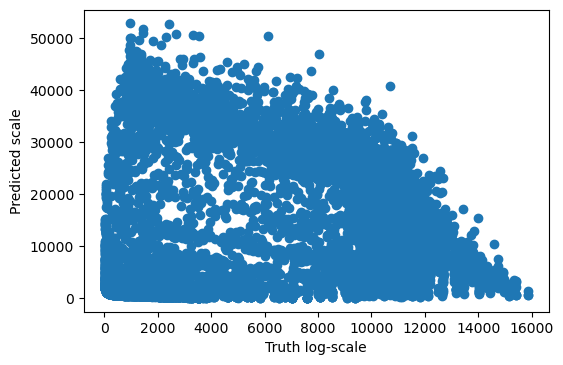

In [25]:
plt.figure(dpi=100)
plt.scatter(np.exp(predicted), np.exp(truth))
#sns.scatterplot(predicted, truth)
plt.xlabel("Truth log-scale")
plt.ylabel("Predicted scale")
plt.show()